Для начала загрузим необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd

#для графиков
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import decomposition
from sklearn import metrics
from sklearn import datasets
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering



Подгрузим датасет с данными по болезням спины

In [2]:
spinal_des = pd.read_csv('column_3C_weka.csv')

In [4]:
spinal_des.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,Hernia
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Hernia
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Hernia
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Hernia
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Hernia


Для кластеризации будем использовать значения параметров "degree_spondylolisthesis" и "pelvic_radius", поэтому с помощью графика seaborn replot посмотрим, как соотносятся значения этих переменных в различных классах

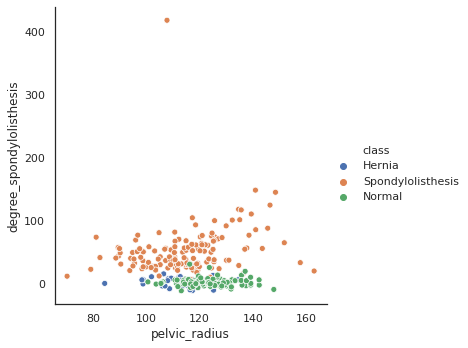

In [58]:
sns.relplot(x = 'pelvic_radius', y = 'degree_spondylolisthesis', hue = 'class', data = spina)

Видим, что у пациентов с спондилолистезом наблюдаются более высокие значения переменной degree_spondylolisthesis, что весьма очевидно, но также видим, что одно значение, относящееся к класу Spondylolisthesis вылетает по переменной degree_spondylolisthesis достаточно сильно. Посмотрим, каковы значения других переменных для данного наблюдения.

In [5]:
spinal_des.loc[(spinal_des.degree_spondylolisthesis > 400),'class']='Possible_outlier'

/home/alexadol/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/alexadol/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/alexadol/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/alexadol/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/alexadol/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/alexadol/anaconda3/lib/python3.7/s

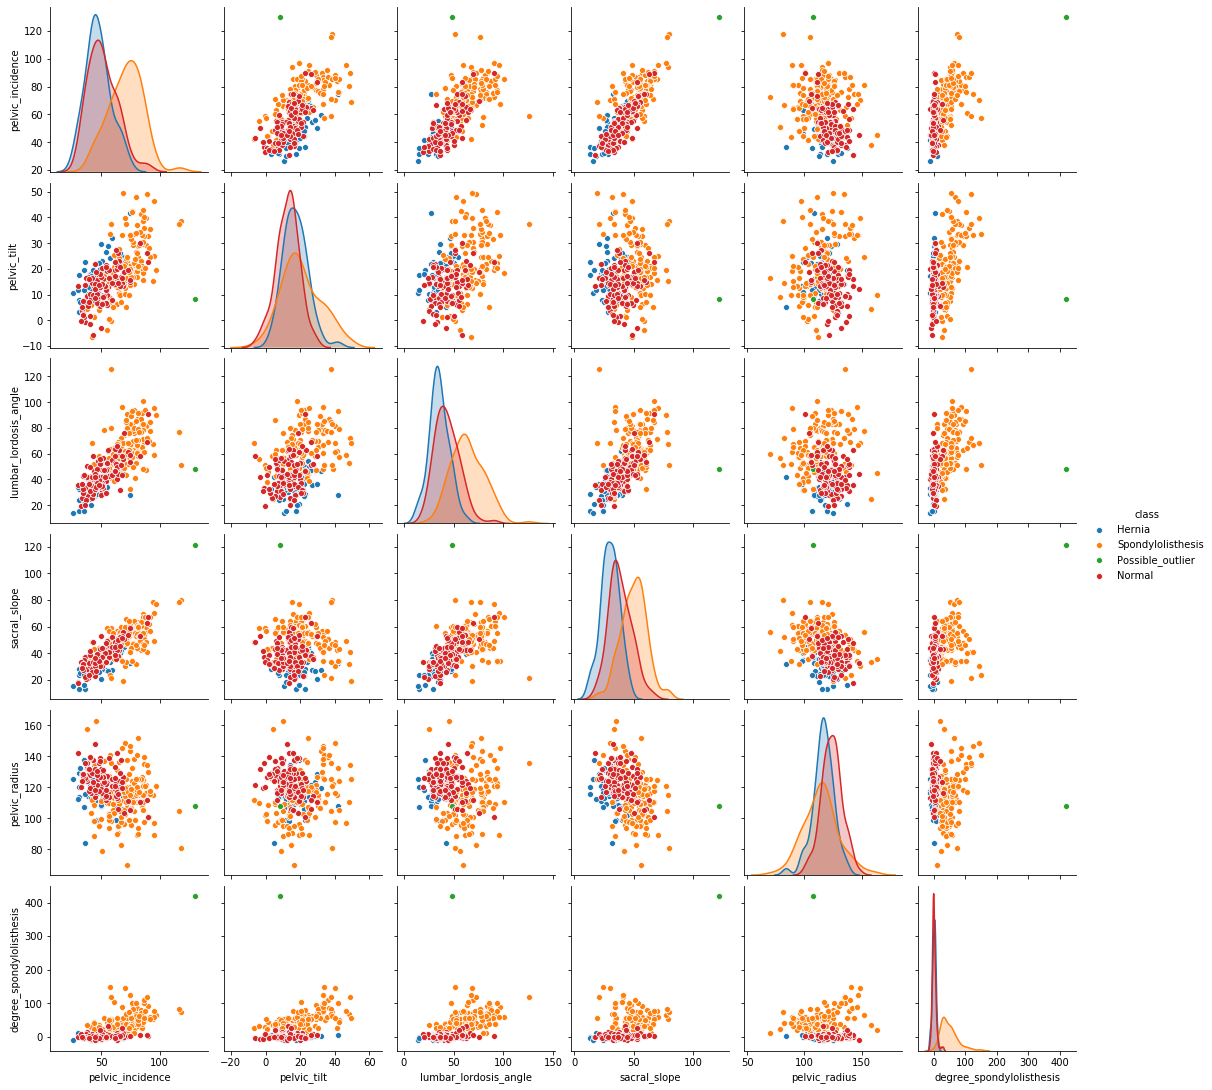

In [7]:
sns.pairplot(spinal_des,hue='class')

Видим, что значения этого наблюдения оказываются сильно выше, чем у других наблюдений и по другим переменным, например pelvic_incidence, а особенно sacral_slope. Посмотрим, как соотносятся значения переменных sacral_slope и degree_spondylolisthesis между собой.

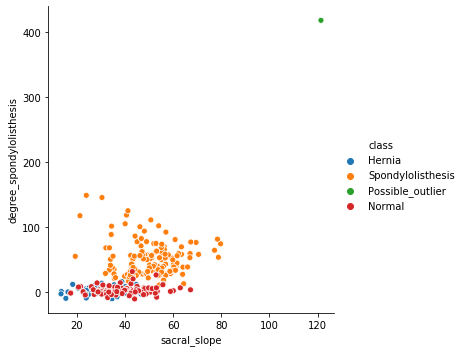

In [8]:
sns.relplot(x = 'sacral_slope', y = 'degree_spondylolisthesis', hue = 'class', data = spinal_des)

Мы видим, что для наблюдения, которое, как мы подозреваем может являться аутлайером, по данным переменным показаны очень высокие значения и при этом очевидной корреляции между данными переменными нет. Так что вероятнее всего, высокие значения данного наблюдения действительно ошибочны и мы можем убрать его из дальнейшего анализа. 

In [9]:
spinal_des.drop(spinal_des[spinal_des.degree_spondylolisthesis > 400].index, inplace=True)

Теперь создадим массив со значениями переменных  "degree_spondylolisthesis" и "pelvic_radius" для дальнейшей кластеризации

In [10]:
x = spinal_des.iloc[:, [4,5]].values

Для рассчета оптимального количества кластеров рассчитаем  сумму квадратов расстояний от точек до центроидов кластеров при разном их количестве и отобразим эти значения на графике. Поскольку чисто визуально видим, что кластеров в нашем случае вряд ли много, поставим range от 1 до 7.

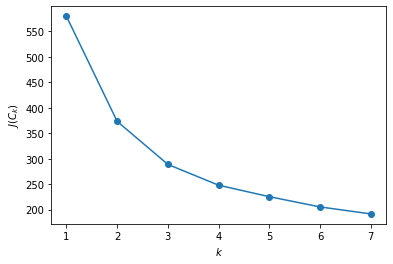

In [12]:
sqrt_inertia = []
for i in range(1, 8):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0)
    km.fit(x)
    sqrt_inertia.append(np.sqrt(km.inertia_))

plt.plot(range(1, 8), sqrt_inertia, marker='o')
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$')
plt.show()

J(Ck) сильно снижается при увеличении количества кластеров с  1 до 2 и с 2 до 3 и уже не так сильно – при изменении с 3 до 4. Значит, в данной задаче оптимально задать 3 кластера.

Теперь создадим классификатор Kmeans на основании полученных данных об оптимальном числе кластеров и проведем кластеризацию

In [13]:
km = KMeans(n_clusters=3, init='random',n_init=10, max_iter=300, tol=1e-04, random_state=0)
y_km = km.fit_predict(x)
km

Используя график scatter plot визуализируем полученные результаты кластеризации

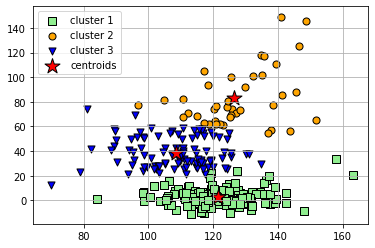

In [16]:
plt.scatter(
    x[y_km == 0, 0], x[y_km == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    x[y_km == 1, 0], x[y_km == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    x[y_km == 2, 0], x[y_km == 2, 1],
    s=50, c='blue',
    marker='v', edgecolor='black',
    label='cluster 3'
)


plt.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

Для сравнения еще раз выведем график, показывающий как в реальности распределены классы

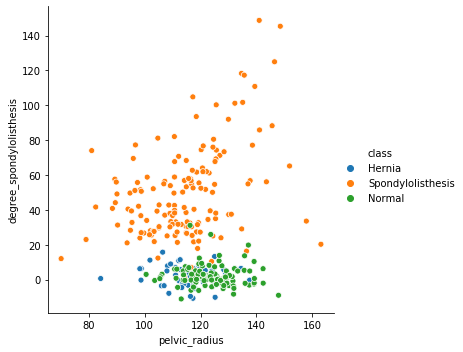

In [18]:
sns.relplot(x = 'pelvic_radius', y = 'degree_spondylolisthesis', hue = 'class', data = spinal_des)

Мы видим, что наблюдения класса Spondylilisthesis классификатор разбил на 2 кластера, но впрочем, как видно, значения для классов Hernia и Normal не образуют четко различимых групп и в реальных данных, так что логично предположить, что проводя кластеризацию по переменным degree_spondylolisthesis и pelvic_radius мы не получим 3 кластера соответствующих реальным трем классам, а значения для классаSpondylilisthesis визуально действительно можно разбить на 2 кластера. 

Теперь перейдем к иерархической кластеризации. Опробуем разные методы кластеризации в рамках иерархического алгоритма, а именно одиночную связь, полную связь и попарное среднее.

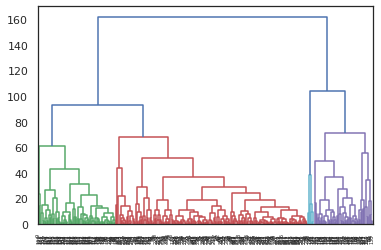

In [85]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist
distance_mat = pdist(x)
Z = hierarchy.linkage(distance_mat, 'complete') 
dn = hierarchy.dendrogram(Z, color_threshold=80)

Как мы видим, метод полной связи справляется неплохо, выделяется 3 больших кластера и небольшой четвертый

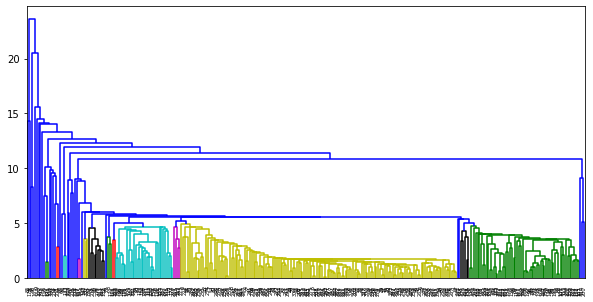

In [24]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist
distance_mat = pdist(x)
Z = hierarchy.linkage(distance_mat, 'single') 
plt.figure(figsize=(10, 5))
dn = hierarchy.dendrogram(Z, color_threshold= 5)

В случае одиночной связи же кластеризация идет значительно хуже. Получается много "вложенных" кластеров и можно сказать образуется цепочка из них. Данный метод очевидно плохо работает на наших данных.

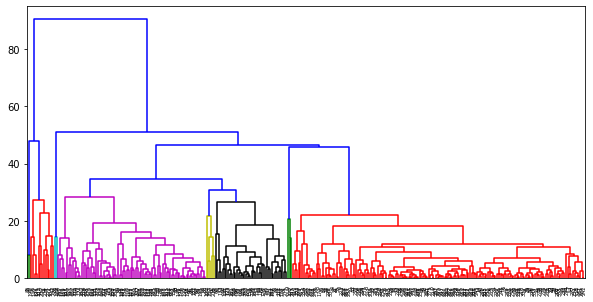

In [27]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist
distance_mat = pdist(x)
Z = hierarchy.linkage(distance_mat, 'average') 
plt.figure(figsize=(10, 5))
dn = hierarchy.dendrogram(Z, color_threshold= 30)

В данном случае метод сработал "средне", так как помимо крупных кластеров выделяет слишком много мелких, но все же ситуация лучше, чем в single linkage.
В итоге, лучше всего на данном наборе данных работает такой метод кластеризации, как complete linkage.

Для оценки качества кластеризации различных алгоритмов создадим переменную, содержащую данные об истинном разбиении выборки на классы. Она понадобится нам для внутренних метрик.

In [28]:
y = spinal_des['class']

Теперь оценим внешние и внутренние метрики качества кластеризации для различных алгоритмов. При этом, посмотрим также, каковы значения этих метрик и для 3 кластеров и для 2. 
Помимо оценки качества работы алгоритмов агломеративной кластеризации и k-means алгоритма на данном наборе данных посмотрим также на оценки качества других алгоритмов, которые мы в данном случае не использовали. Это Affinity Propagation, который вообще не требует предварительно определить количество кластеров, а выделяет их сам на основе "схожести" объектов и спектральная кластеризация, оперирущая матрицей схожести наблюдений.

In [25]:
algorithms = []
algorithms.append(KMeans(n_clusters=3, random_state=1))
algorithms.append(KMeans(n_clusters=2, random_state=1))
algorithms.append(AffinityPropagation())
algorithms.append(SpectralClustering(n_clusters=3, random_state=1,
                                     affinity='nearest_neighbors'))
algorithms.append(AgglomerativeClustering(n_clusters=3,linkage = 'complete'))
algorithms.append(AgglomerativeClustering(n_clusters=2,linkage = 'complete'))
algorithms.append(AgglomerativeClustering(n_clusters=3,linkage = 'single'))
algorithms.append(AgglomerativeClustering(n_clusters=2,linkage = 'single'))
algorithms.append(AgglomerativeClustering(n_clusters=3,linkage = 'average'))
algorithms.append(AgglomerativeClustering(n_clusters=2,linkage = 'average'))


data = []
for algo in algorithms:
    algo.fit(x)
    data.append(({
        'ARI': metrics.adjusted_rand_score(y, algo.labels_),
        'AMI': metrics.adjusted_mutual_info_score(y, algo.labels_),
        'Homogenity': metrics.homogeneity_score(y, algo.labels_),
        'Completeness': metrics.completeness_score(y, algo.labels_),
        'V-measure': metrics.v_measure_score(y, algo.labels_),
        'Silhouette': metrics.silhouette_score(x, algo.labels_)}))

results = pd.DataFrame(data=data, columns=['ARI', 'AMI','Homogenity'
                                           'Completeness', 'V-measure', 
                                           'Silhouette'],
                       index=['K-means_3','K-means_2','Affinity', 
                              'Spectral', 'Agglomerative_3_c','Agglomerative_2_c','Agglomerative_3_s',
                              'Agglomerative_2_s','Agglomerative_3_a','Agglomerative_2_a'])

results

,ARI,AMI,HomogenityCompleteness,V-measure,Silhouette
K-means_3,0.410439,0.530457,NaN,0.533551,0.522468
K-means_2,0.184625,0.352642,NaN,0.355211,0.550135
Affinity,0.123156,0.318932,NaN,0.344570,0.361751
Spectral,0.404400,0.541187,NaN,0.544119,0.485692
Agglomerative_3_c,0.002182,0.203072,NaN,0.210229,0.509578
Agglomerative_2_c,0.017778,0.215547,NaN,0.218918,0.550549
Agglomerative_3_s,-0.008638,0.003132,NaN,0.017128,0.281408
Agglomerative_2_s,-0.004381,0.001569,NaN,0.008832,0.278556
Agglomerative_3_a,-0.028814,0.055008,NaN,0.066011,0.344587
Agglomerative_2_a,-0.025447,0.054429,NaN,0.059774,0.589202


Если мы по смотрим на внешнюю метрику - силуэт, то увидим что по ней максимальное значение имеет агломеративная кластеризация методом попарных средних при разбиении на 2 кластера, а чуть ниже окажутся агломеративная кластеризация методом полной связи и k-means для 2 кластеров. И действительно, если вспомнить, как выглядят наши данные то без учета априорного знания о делении на классы разбиение на 2 кластера кажется наиболее правильным. 

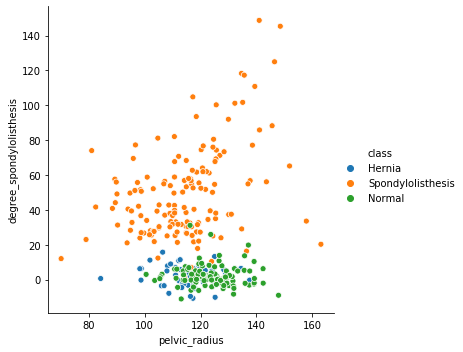

In [29]:
sns.relplot(x = 'pelvic_radius', y = 'degree_spondylolisthesis', hue = 'class', data = spinal_des)

Посмотрим, например, как будет выглядеть разбиение с помощью k-means на два класса

In [30]:
km = KMeans(n_clusters=2, init='random',n_init=10, max_iter=300, tol=1e-04, random_state=0)
y_km = km.fit_predict(x)


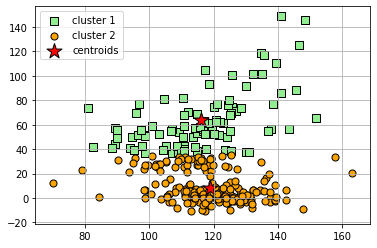

In [31]:
plt.scatter(
    x[y_km == 0, 0], x[y_km == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    x[y_km == 1, 0], x[y_km == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)



plt.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

Чисто визуально такая кластеризация кажется более подходящей под реальные данные, но поскольку у нас в данных присутствует три класса, то понятно, что для многих объектов принадлежность к исходному классу и к выделенному кластеру окажутся несогласованными и поэтому у k-means для 2-х кластеров мы наблюдаем сильное снижение значений внутренних метрик ARI и AMI. Но вместе с тем,для агломеративных алгоритмов эт значения этих метрик оказываются вообще близки к нулю, что говорит о том, что выделение объектов в кластеры близко к случайному. 

Поскольку в данном датасете разделить значения degree_spondylolisthesis и pelvic_cluster для классов "грыжа" и "нормальное состояни" по-видимому действительно практически невозможно, в данном случае можно довериться внешней метрике -силуэт и выбрать в качестве лучшего алгоритм k-means и оптимальным - разбиение на 2 кластера, так как в данном случае и внутренние метрики оказываются не так низки, как у агломеративного. Но так или иначе, сделать однозначный выбор в данном случае сложно. 